# TP 2 de Video Processing

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import calendar
import time
import cv2
import numpy as np
from tqdm import tqdm

In [6]:
PATH_TO_IMG_DIRECTORY = '../images/'

## **Question (A)**
Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre F1 et F2.

Procédez maintenant à de l’estimation backward par blocs entre F1 et F2.

In [8]:
def load_img_array(img_path :str) -> np.ndarray :
    img = Image.open(img_path)
    return np.asarray(img)

In [9]:
def display_image(array, now = True, vmin = None, vmax = None):
    """Display 2D array as image"""
    plt.imshow(array, cmap = plt.cm.gray, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    if now:
        plt.show()
def display_images(images, lines = None, columns = None, indices = None, vmin = None, vmax = None):
    """Display a list of 2D arrays as images"""
    if columns is None:
        if lines is None:
            columns = int(np.ceil(np.sqrt(len(images))))
        else:
            columns = int(np.ceil(float(len(images)) / lines))
    if lines is None:
        lines = int(np.ceil(float(len(images)) / columns))
    if indices is None:
        indices = range(1, len(images) + 1)
    for k in range(len(images)):
        if not images[k] is None:
            plt.subplot(lines, columns, indices[k])
            display_image(images[k], vmin = vmin, vmax = vmax, now = False)
    plt.show()

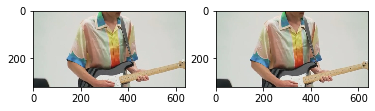

In [11]:
f1 = load_img_array(os.path.join(PATH_TO_IMG_DIRECTORY,'LF016.jpg'))
f2 = load_img_array(os.path.join(PATH_TO_IMG_DIRECTORY,'LF017.jpg'))
display_images([f1,f2])

In [35]:
class BackWardEstimator():
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ) -> None:
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.f2 = np.asarray(img2)
        self.f1 = np.asarray(img1)
        self.window_size = 10
        self.flow_vectors = []
    
    def get_min_error_block(self,x :int,y:int) -> tuple:
        height, width = self.f2.shape[:2]
        left_x_bound = max(x-self.window_size,0)
        right_x_bound = min(x+self.window_size,height-self.block_size)
        left_y_bound = max(y-self.window_size,0)
        right_y_bound = min(y+self.window_size,width-self.block_size)
        block_1 = self.f2[x:x+self.block_size,y:y+self.block_size].astype(int)
        min_cost = float('inf')
        best_match = (0,0)
        for i in range(left_x_bound,right_x_bound):
            for j in range(left_y_bound,right_y_bound):
                block_2 = self.f1[i:i+self.block_size,j:j+self.block_size].astype(int)
                assert(block_1.shape == block_2.shape  or print(x,y,block_1.shape,block_2.shape,i,j,left_y_bound,right_y_bound))
                cost = np.mean(np.abs(block_1 - block_2))
                if(cost < min_cost):
                    min_cost = cost
                    best_match = (x,y,x-i,y-j)
    
        return best_match
    
    def back_ward_estimation(self) -> np.ndarray :
        height, width = self.f2.shape[:2]
        for x in tqdm(range(0,height-self.block_size+1,self.block_size)):
            for y in (range(0,width-self.block_size+1,self.block_size)):
                best_match = self.get_min_error_block(x,y)
                self.flow_vectors.append(best_match)
                
        img_to_display = np.copy(self.f2)
        for point in self.flow_vectors:
            x,y,dx,dy = point
            cv2.arrowedLine( img_to_display,(y,x), (int(dy+y),int(dx+x)), (0, 0, 0),1)
        
        print(f'Backward estimation by block wise method with {self.block_size} for block size and {self.window_size} for window size.')
        return img_to_display
    
    def __call__(self,block_size:int = 5) -> None:
        self.block_size = block_size
        return self.back_ward_estimation()

In [61]:
backward_estimator = BackWardEstimator(os.path.join(PATH_TO_IMG_DIRECTORY,'LF016.jpg'),os.path.join(PATH_TO_IMG_DIRECTORY,'LF017.jpg'))

In [62]:
img_to_display = backward_estimator(block_size=15)

100%|██████████| 21/21 [00:04<00:00,  4.36it/s]

Backward estimation by block wise method with 15 for block size and 10 for window size.


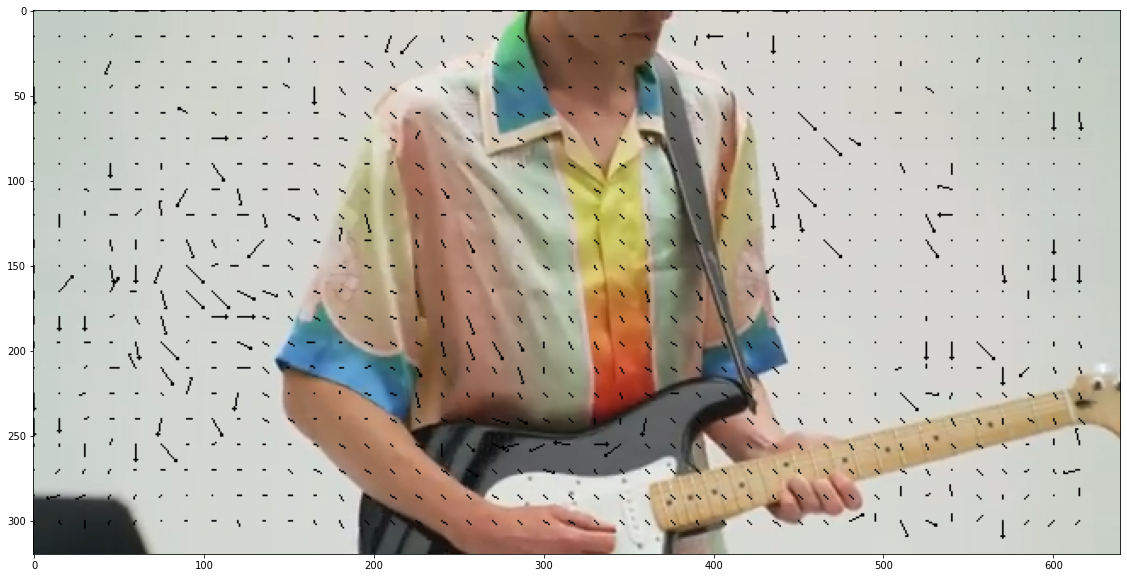

In [63]:
fig, ax = plt.subplots(figsize =(20, 10))
plt.imshow(img_to_display)

## **Question (B)**
* Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ?
    
    On veut connaitre la frame de F2 à partir de F1, il convient donc de connaitre l'estimation de mouvement de F2 vers F1.

* Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)
    
    Nous aurions obtenu sûrement une estimation de mouvement incohérente, et du bruit dans l'image.

## **Question (C)**
Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?


In [64]:
new_img = np.zeros((f1.shape)).astype(np.uint8)


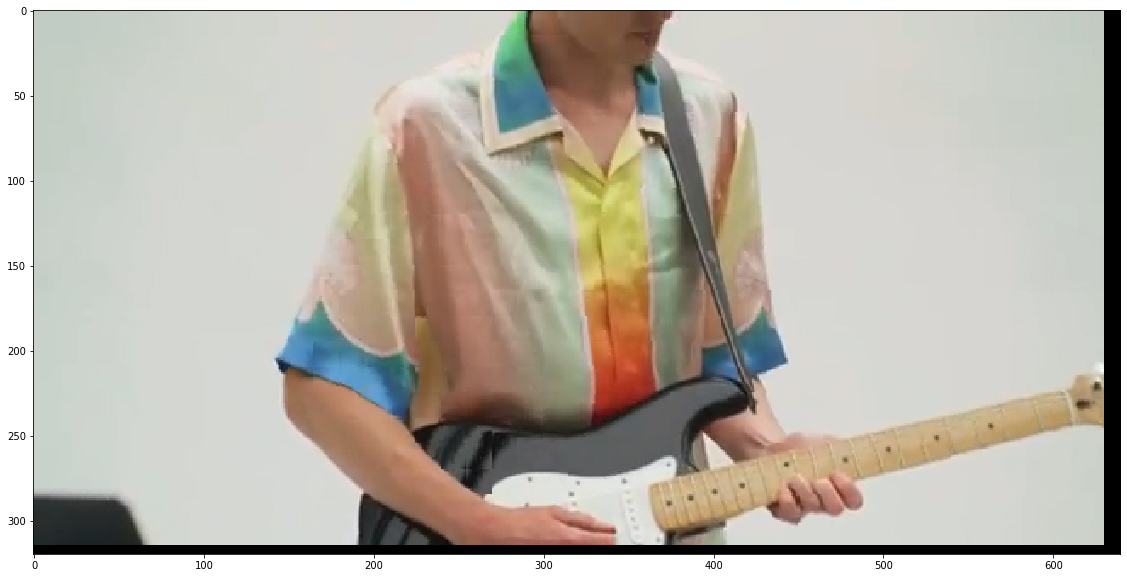

In [68]:
def predict_and_display_f2(backward_estimator :BackWardEstimator) -> None:
    for vec in backward_estimator.flow_vectors:
        x,y,dx,dy = vec
        f1_x = x-dx
        f1_y = y-dy 
        block_size = backward_estimator.block_size
        new_img[x:x+block_size,y:y+block_size] = f1[f1_x:f1_x+block_size:,f1_y:f1_y+block_size]
    fig, ax = plt.subplots(figsize =(20, 10))
    display_image(new_img)
   
predict_and_display_f2(backward_estimator)       

**Observations:**

On remarque ici l'aspect quadrillé de la reconstruction par bloc, notamment au niveau de la guitare.

## **Question (D)**
Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?


Il faut le **champs de vecteur de l'estimation backward**, a

## **Question (E)**
Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

## **Question (F)**
Expliquez quelles données on peut coder avec perte pour garder une
qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

## **Question (G)**
Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.